In [51]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
import scipy.cluster
import shap

In [52]:
deposit_data = pd.read_csv("../../Curated_data/final_dataset.csv", low_memory=False)


In [53]:
phi_columns

['PO_Total',
 'PY_Total',
 'phi_0',
 'phi_1',
 'phi_2',
 'phi_3',
 'phi_4',
 'phi_5',
 'phi_6',
 'phi_7',
 'phi_8',
 'phi_9',
 'phi_10',
 'phi_11',
 'phi_12',
 'phi_13',
 'phi_14',
 'phi_15',
 'phi_16',
 'phi_17',
 'phi_18',
 'phi_19',
 'phi_20',
 'phi_21',
 'phi_22',
 'phi_23',
 'phi_24',
 'phi_25',
 'phi_26',
 'phi_27',
 'phi_28',
 'phi_29',
 'phi_30',
 'phi_31',
 'phi_32',
 'phi_33',
 'phi_34',
 'phi_35',
 'phi_36',
 'phi_37',
 'phi_38',
 'phi_39',
 'phi_40',
 'phi_41',
 'phi_42',
 'phi_43',
 'phi_44',
 'phi_45',
 'phi_46',
 'phi_47',
 'phi_48',
 'phi_49',
 'phi_50',
 'phi_51',
 'phi_52',
 'phi_53',
 'phi_54',
 'phi_55',
 'phi_56',
 'phi_57',
 'phi_58',
 'phi_59',
 'phi_60',
 'phi_61',
 'phi_62',
 'phi_63',
 'phi_64',
 'phi_65',
 'phi_66',
 'phi_67',
 'phi_68',
 'phi_69',
 'phi_70',
 'phi_71',
 'phi_72',
 'phi_73',
 'phi_74',
 'phi_75',
 'phi_76',
 'phi_77',
 'phi_78',
 'phi_79',
 'phi_80',
 'phi_81',
 'phi_82',
 'phi_83',
 'phi_84',
 'phi_85',
 'phi_86',
 'phi_87',
 'phi_88',
 'phi

In [54]:
#deposit_data['Random_Values'] = np.random.rand(len(deposit_data))

In [62]:
# Assuming deposit_data is your DataFrame
# Extract the names of the first 98 columns
phi_columns = deposit_data.columns[10:].tolist()

# Display the list of column names
print(phi_columns[-1])


phi_6402


In [64]:
total_columns = ['CP_Total','PO_Total', 'PY_Total']

#all covariates
#covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm', 'Random_Values'] 

covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm'] 

In [65]:
deposit_data = deposit_data.dropna(subset=['Density_gcm3'] + covariates + phi_columns)

In [66]:
p = len(phi_columns) + len(covariates)

In [59]:
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

In [67]:
deposit_data[phi_columns + covariates]

,phi_0,phi_1,phi_2,phi_3,phi_4,phi_5,phi_6,phi_7,phi_8,phi_9,...,phi_6398,phi_6399,phi_6400,phi_6401,phi_6402,CP_Total,PO_Total,PY_Total,RQD_Pct,Cr_ppm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.250,0.066667,0.0,0.8800,0.127305
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.250,0.066667,0.0,0.8800,0.160479
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.250,0.066667,0.0,0.9900,0.128743
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.375,0.133333,0.0,0.9900,0.141317
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.500,0.200000,0.0,0.9900,0.153293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000246,0.003618,0.000032,...,0.0,0.0,0.0,0.0,0.0,0.050,0.200000,0.0,0.9235,0.078443
2614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000262,0.003631,0.000029,...,0.0,0.0,0.0,0.0,0.0,0.050,0.200000,0.0,0.9235,0.074850
2615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000279,0.003641,0.000027,...,0.0,0.0,0.0,0.0,0.0,0.050,0.200000,0.0,0.8584,0.076647
2616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000297,0.003651,0.000025,...,0.0,0.0,0.0,0.0,0.0,0.050,0.200000,0.0,0.8584,0.077246


# Deepkriging train test split

In [68]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

phi_columns = deposit_data.columns[10:-1].tolist()

torch.manual_seed(42)
np.random.seed(42)

p = len(phi_columns) + len(covariates)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(deposit_data[phi_columns + covariates],
                                                    deposit_data['Density_gcm3'],
                                                    test_size=0.2, random_state=42)

# Define the neural network
model = nn.Sequential(
    nn.Linear(in_features=p, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=1))

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

# Training loop
for step in range(601):
    pre = model(torch.tensor(X_train.values, dtype=torch.float32))
    mse = mse_loss(pre, torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32))
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()


torch.manual_seed(42)
np.random.seed(42)
# Store metrics for this fold
test_predictions = model(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().flatten()

# Print metrics for the test set
print_metrics(y_test.values, test_predictions, "Test")



Metrics for Test set:
  MSE: 0.0030
  RMSE: 0.0550
  MAE: 0.0383
  R^2: 0.7927



# Combinations for the phi feature

In [78]:
len(phi_columns)

6402

In [79]:
# Create all possible combinations of columns and generate a new DataFrame for each combination
import pandas as pd
from itertools import combinations
X_phi_c = X_test.iloc[:, len(phi_columns):]
X_easy = X_phi_c
X_phi = X_test.iloc[:, :len(phi_columns)]

permutations_phi = []
Q = []
#covariates + phi - active variable
size = len(covariates) + 1 - 1
Q.append(size)

#To get all combinations in X_easy 
numcovar = len(covariates) - 1

#The first df corresponds to the full dataset
permutations_phi.append(pd.concat([X_easy.copy(), X_phi], axis=1))

#Compute all X_easy combinations and then append X_phi
for r in range(1, len(X_easy.columns) + 1):
    for combo in combinations(X_easy.columns, r):
        new_df = X_easy.copy()
        new_df[list(combo)] = 0
        permutations_phi.append(pd.concat([new_df, X_phi], axis=1))

permutations_phi_0 = []

# Create a DataFrame with all columns in X_phi set to 0
zero_X_phi = pd.DataFrame(0, index=X_phi.index, columns=X_phi.columns)

#The first df corresponds to the full dataset, but with the phi's set to 0
permutations_phi_0.append(pd.concat([X_easy.copy(), zero_X_phi], axis=1))

#Compute all X_easy combinations and then append the phi columns with 0s (these are the subsets without the j variable)
for r in range(1, len(X_easy.columns) + 1):
    for combo in combinations(X_easy.columns, r):
        new_df = X_easy.copy()
        new_df[list(combo)] = 0
        permutations_phi_0.append(pd.concat([new_df, zero_X_phi], axis=1))
        n_features = len(X_easy.columns[-numcovar:]) + 1 - len(combo)
        Q.append(n_features)



permutations_phi = [df[X_test.columns] for df in permutations_phi]
permutations_phi_0 = [df[X_test.columns] for df in permutations_phi_0]

Q_phi = Q

# Combinations for the rest of the features

In [ ]:
import pandas as pd
from itertools import combinations

X_CP_Total = X_test[['CP_Total']]
selected_columns = [col for col in X_test.columns if col != 'CP_Total']
X_CP_Total_c = X_test[selected_columns]

new_dataframes_CP_Total = []
Q = []
new_dataframes_CP_Total.append(pd.concat([X_CP_Total_c.copy(), X_CP_Total], axis=1))

numcovar = len(covariates)-1
#covariates + phi - active variable
size = len(covariates)-1+1
Q.append(size)

for r in range(1, len(X_CP_Total_c.columns[-numcovar:]) + 1):
    for combo in combinations(X_CP_Total_c.columns[-numcovar:], r):
        new_df = X_CP_Total_c.copy()
        new_df[list(combo)] = 0
        new_dataframes_CP_Total.append(pd.concat([new_df, X_CP_Total], axis=1))
        # 4 features + phi feature - the number of features being 0 is the number of active features 


for idx in range(len(new_dataframes_CP_Total)):
    new_df = new_dataframes_CP_Total[idx].copy()
    for col in new_df.columns[:6403]:
        new_df[col].values[:] = 0
    new_dataframes_CP_Total.append(new_df)



# Subtract one from each element using list comprehension



new_dataframes_CP_Total_aux = new_dataframes_CP_Total

# Assuming X_CP_Total_c is your existing DataFrame and X_CP_Total is another DataFrame
# Create all possible combinations of columns and generate a new DataFrame for each combination
new_dataframes_CP_Total_0 = []

# Create a DataFrame with all columns in X_CP_Total set to 0
zero_X_CP = pd.DataFrame(0, index=X_CP_Total.index, columns=X_CP_Total.columns)

new_dataframes_CP_Total_0.append(pd.concat([X_CP_Total_c.copy(), zero_X_CP], axis=1))


for r in range(1, len(X_CP_Total_c.columns[-numcovar:]) + 1):
    for combo in combinations(X_CP_Total_c.columns[-numcovar:], r):
        new_df = X_CP_Total_c.copy()
        new_df[list(combo)] = 0
        new_dataframes_CP_Total_0.append(pd.concat([new_df, zero_X_CP], axis=1))
        n_features = len(X_CP_Total_c.columns[-numcovar:]) + 1 - len(combo)
        Q.append(n_features)



for idx in range(len(new_dataframes_CP_Total_0)):
    new_df = new_dataframes_CP_Total_0[idx].copy()
    for col in new_df.columns[:6403]:
        new_df[col].values[:] = 0
    new_dataframes_CP_Total_0.append(new_df)


result_list = [x - 1 for x in Q]
Q = Q + result_list


all_subgroups_CP_Total = new_dataframes_CP_Total + new_dataframes_CP_Total_0
len(all_subgroups_CP_Total)

64

In [80]:
Q

[5,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 0]

In [83]:
import pandas as pd
from itertools import combinations

# Create all possible combinations of columns and generate a new DataFrame for each combination
def subgroups(column):

# Column of interest
    X_column = X_test[[column]]

# Select all other columns
    selected_columns = [col for col in X_test.columns if col != column]
    X_column_c = X_test[selected_columns]

# Covariates + phi - active variable
    size = len(covariates) + 1 - 1

    numcovar = len(covariates) - 1
############### Phase 1: create all combinations of the data WITH the column of interest's original values ###############
    
    new_dataframes_column = []

# The first dataframe is all columns are active
    new_dataframes_column.append(pd.concat([X_column_c.copy(), X_column], axis=1))

# The first loop goes over the number of selected columns. r represents the number of inactive cols.
# The second loop goes over all the combinations of the selected columns excluding the phi variables
    for r in range(1, len(X_column_c.columns[-numcovar:]) + 1):
        for combo in combinations(X_column_c.columns[-numcovar:], r):
            new_df = X_column_c.copy()
            new_df[list(combo)] = 0
            new_dataframes_column.append(pd.concat([new_df, X_column], axis=1))

# The last loop created all combinations with the activated phi values, in this one we make a copy with phi values equal to 0 
    for idx in range(len(new_dataframes_column)):
        new_df = new_dataframes_column[idx].copy()
        for col in new_df.columns[:len(phi_columns)]:
            new_df[col].values[:] = 0
        new_dataframes_column.append(new_df)


############### Phase 2: create all combinations of the data WITHOUT the column of interest original values (set to 0) ###############


    new_dataframes_column_0 = []

# Create a DataFrame with all values in X_column set to 0
    zero_X_CP = pd.DataFrame(0, index=X_column.index, columns=X_column.columns)

#The first dataframe is all columns active but the one of interest
    new_dataframes_column_0.append(pd.concat([X_column_c.copy(), zero_X_CP], axis=1))

# Amount of active variables for each dataframe
    Q = []

# First dataframe is all active but one 
    Q.append(size)
    
# The first loop goes over the number of selected columns. r represents the number of inactive cols.
# The second loop goes over all the combinations of the selected columns excluding the phi variables
    for r in range(1, len(X_column_c.columns[-numcovar:]) + 1):
        for combo in combinations(X_column_c.columns[-numcovar:], r):
            new_df = X_column_c.copy()
            new_df[list(combo)] = 0
            new_dataframes_column_0.append(pd.concat([new_df, zero_X_CP], axis=1))
            n_features = len(X_CP_Total_c.columns[-numcovar:]) + 1 - len(combo)
            Q.append(n_features)

# The last loop created all combinations with the activated phi values, in this one we make a copy with phi values equal to 0 
    for idx in range(len(new_dataframes_column_0)):
        new_df = new_dataframes_column_0[idx].copy()
        for col in new_df.columns[:len(phi_columns)]:
            new_df[col].values[:] = 0
        new_dataframes_column_0.append(new_df)

# Appending the number of active variables of the second loop, which has one less because phi cols are inactive
    result_list = [x - 1 for x in Q]
    Q = Q + result_list

    sorted_dfs1 = [df[X_test.columns] for df in new_dataframes_column]
    sorted_dfs2 = [df[X_test.columns] for df in new_dataframes_column_0]

    return sorted_dfs1, sorted_dfs2, Q

In [84]:
for col in X_easy.columns.tolist():
    exec(f"permutations_{col}, permutations_{col}_0, Q_{col} = subgroups('{col}')")

In [85]:
X_easy.columns.tolist()

['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']

In [86]:
# import math


# psi_Random_Values = 0 
# # all covariates are covariates + phi
# S_abs = len(covariates) + 1
# S_fact = math.factorial(S_abs)
# for i in range(len(permutations_Random_Values)):
#                Q_c = model(torch.tensor(permutations_Random_Values_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
#                Q = model(torch.tensor(permutations_Random_Values[i].values, dtype=torch.float32)).detach().numpy().flatten()
#                weight = math.factorial(Q_Random_Values[i])*math.factorial(S_abs - Q_Random_Values[i] - 1)*(1/S_fact)
#                contr = Q - Q_c
#                summand = weight*contr
#                psi_Random_Values = psi_Random_Values + summand



In [87]:
psi_CP_Total = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_CP_Total)):
               Q_c = model(torch.tensor(permutations_CP_Total_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_CP_Total[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_CP_Total[i])*math.factorial(S_abs - Q_CP_Total[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_CP_Total = psi_CP_Total + summand

In [88]:
psi_PY_Total = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_PY_Total)):
               Q_c = model(torch.tensor(permutations_PY_Total_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_PY_Total[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_PY_Total[i])*math.factorial(S_abs - Q_PY_Total[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_PY_Total = psi_PY_Total + summand

In [89]:
psi_PO_Total = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_PO_Total)):
               Q_c = model(torch.tensor(permutations_PO_Total_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_PO_Total[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_PO_Total[i])*math.factorial(S_abs - Q_PO_Total[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_PO_Total = psi_PO_Total + summand

In [90]:
psi_RQD_Pct = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_RQD_Pct)):
               Q_c = model(torch.tensor(permutations_RQD_Pct_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_RQD_Pct[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_RQD_Pct[i])*math.factorial(S_abs - Q_RQD_Pct[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_RQD_Pct = psi_RQD_Pct + summand

In [91]:
psi_Cr_ppm = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_Cr_ppm)):
               Q_c = model(torch.tensor(permutations_Cr_ppm_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_Cr_ppm[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_Cr_ppm[i])*math.factorial(S_abs - Q_Cr_ppm[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_Cr_ppm = psi_Cr_ppm + summand

In [92]:
psi_phi = 0 
# all covariates are covariates + phi
S_abs = len(covariates) + 1
S_fact = math.factorial(S_abs)
for i in range(len(permutations_phi)):
               Q_c = model(torch.tensor(permutations_phi_0[i].values, dtype=torch.float32)).detach().numpy().flatten()
               Q = model(torch.tensor(permutations_phi[i].values, dtype=torch.float32)).detach().numpy().flatten()
               weight = math.factorial(Q_phi[i])*math.factorial(S_abs - Q_phi[i] - 1)*(1/S_fact)
               contr = Q - Q_c
               summand = weight*contr
               psi_phi = psi_phi + summand

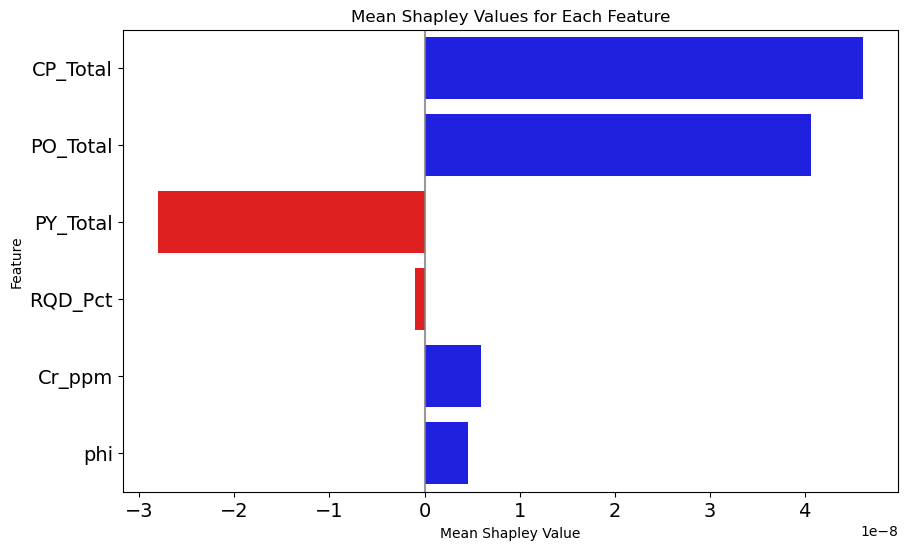

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm, psi_Random_Values,
# psi_phi, and X_test are your variables and DataFrame
# Replace these with your actual data

# Calculate means of each array
mean_psi_CP_Total = np.mean(psi_CP_Total)
mean_psi_PO_Total = np.mean(psi_PO_Total)
mean_psi_PY_Total = np.mean(psi_PY_Total)
mean_psi_RQD_Pct = np.mean(psi_RQD_Pct)
mean_psi_Cr_ppm = np.mean(psi_Cr_ppm)
mean_psi_phi = np.mean(psi_phi)

# Save means in a DataFrame
df_means = pd.DataFrame({
    'Feature': ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm', 'phi'],
    'Mean Shapley Value': [mean_psi_CP_Total, mean_psi_PO_Total, mean_psi_PY_Total, mean_psi_RQD_Pct, mean_psi_Cr_ppm, mean_psi_phi]
})

# Bar plot for mean Shapley values with a single color
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue' if val >= 0 else 'red' for val in df_means['Mean Shapley Value']]
sns.barplot(x='Mean Shapley Value', y='Feature', data=df_means, palette=colors, orient='h')
ax.axvline(0, c="grey", alpha=0.8)
ax.set_xlabel('Mean Shapley Value')
ax.set_ylabel('Feature')
ax.set_title('Mean Shapley Values for Each Feature')

# Increase tick font size
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.show()


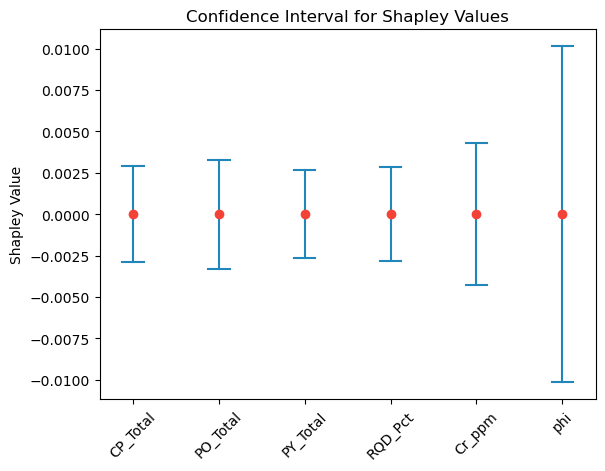

In [97]:
import matplotlib.pyplot as plt
from math import sqrt
import statistics

def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = np.mean(values)
    stdev = np.std(values)
    confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval

# Replace these with your actual data
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm', 'phi']
shapley_values = [psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm, psi_phi]

plt.xticks(range(1, len(features)+1), features, rotation='45')
plt.title('Confidence Interval for Shapley Values')

plt.ylabel('Shapley Value')  
#plt.xlabel('Feature')  


for i, (feature, values) in enumerate(zip(features, shapley_values), start=1):
    plot_confidence_interval(i, values, color='#2187bb')

plt.show()


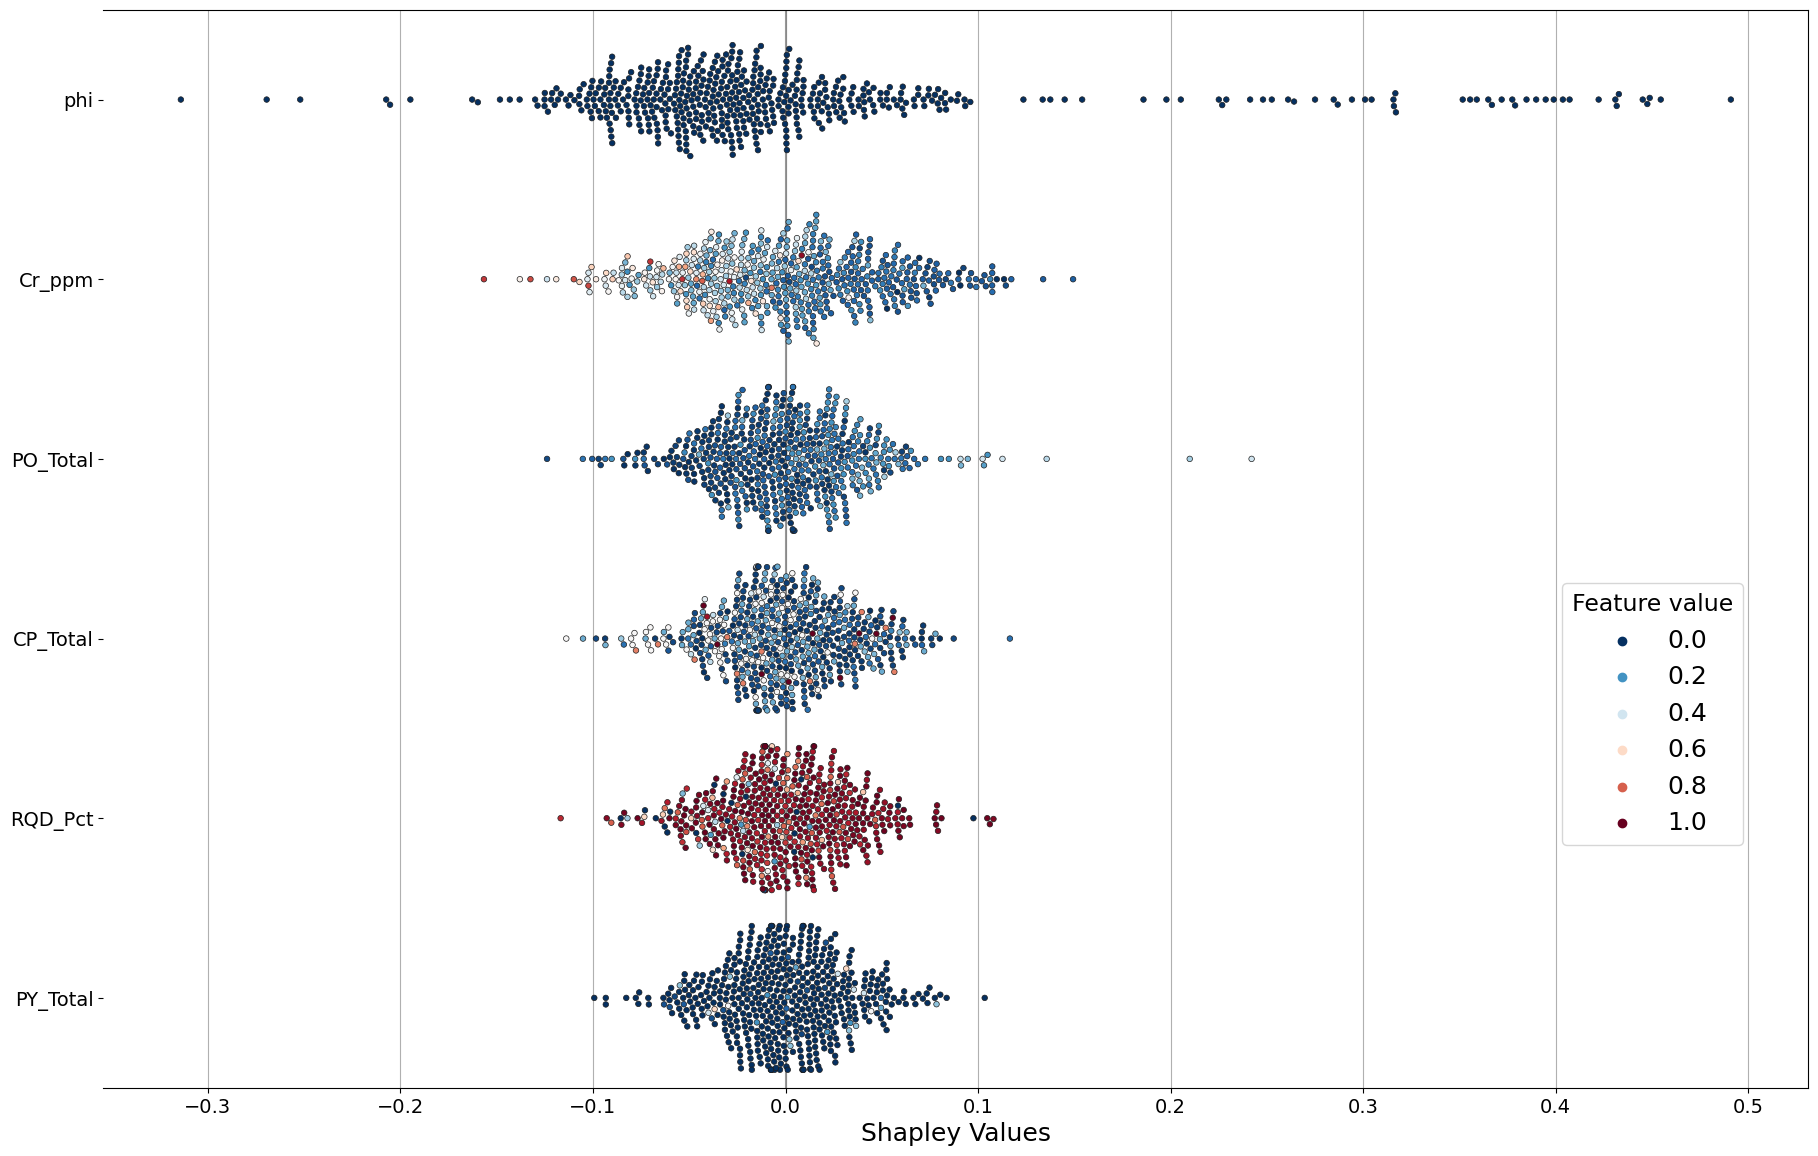

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm, psi_Random_Values,
# psi_phi, and X_test are your variables and DataFrame
# Replace these with your actual data

# Create DataFrames for the beeswarm plot
df_sv = pd.DataFrame()

# List of features
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']

# Populate the DataFrame with features, shapley values, and hue values
df_sv['feature'] = sum([[feature] * len(X_test) for feature in features], [])
df_sv['shapley value'] = np.concatenate([psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm])
df_sv['hue'] = np.concatenate([X_test[feature].values for feature in features])

# Add phi data to the existing DataFrame
mean_df = pd.DataFrame()
mean_df['Mean'] = X_phi.mean(axis=1)
df_sv_phi = pd.DataFrame()
df_sv_phi["feature"] = ["phi"] * len(X_test)
df_sv_phi["shapley value"] = psi_phi
df_sv_phi['hue'] = mean_df['Mean'].values

df_sv = pd.concat([df_sv, df_sv_phi])

# Calculate the absolute sum of Shapley values for each feature
abs_sum_shapley = df_sv.groupby('feature')['shapley value'].apply(lambda x: np.sum(np.abs(x)))
feature_order = abs_sum_shapley.sort_values(ascending=False).index

# Sort the DataFrame based on the feature order
df_sv['feature'] = pd.Categorical(df_sv['feature'], categories=feature_order, ordered=True)
df_sv = df_sv.sort_values('feature')

# Beeswarm plot with stronger reds and blues
fig, ax = plt.subplots(figsize=(22, 14))  # Set the figure size (width, height)
ax.axvline(0, c="grey", alpha=0.8)
sns.swarmplot(
    x=df_sv['shapley value'],
    y=df_sv['feature'],
    hue=df_sv['hue'],
    palette=sns.color_palette("RdBu_r", as_cmap=True),  # Stronger red and blue colors
    size=4,
    linewidth=0.5  # Set linewidth for edges
)
ax.spines.left.set_visible(False)
ax.grid(axis='x')
ax.set_ylabel("")

# Increase x-axis and y-axis tick font size
ax.tick_params(axis='x', labelsize=14)  # Adjust the labelsize as needed
ax.tick_params(axis='y', labelsize=14)  # Adjust the labelsize as needed
ax.set_xlabel("Shapley Values", fontsize=18)

# Increase overall legend font size
legend = plt.legend(title='Feature value', loc='upper right', bbox_to_anchor=(0.969, 0.48), borderaxespad=0.5, fontsize='18')
legend.get_title().set_fontsize('17') 
plt.show()


34.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
34.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
34.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
26.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
34.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
26.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
13.4% of the points cannot be placed; you may want to d

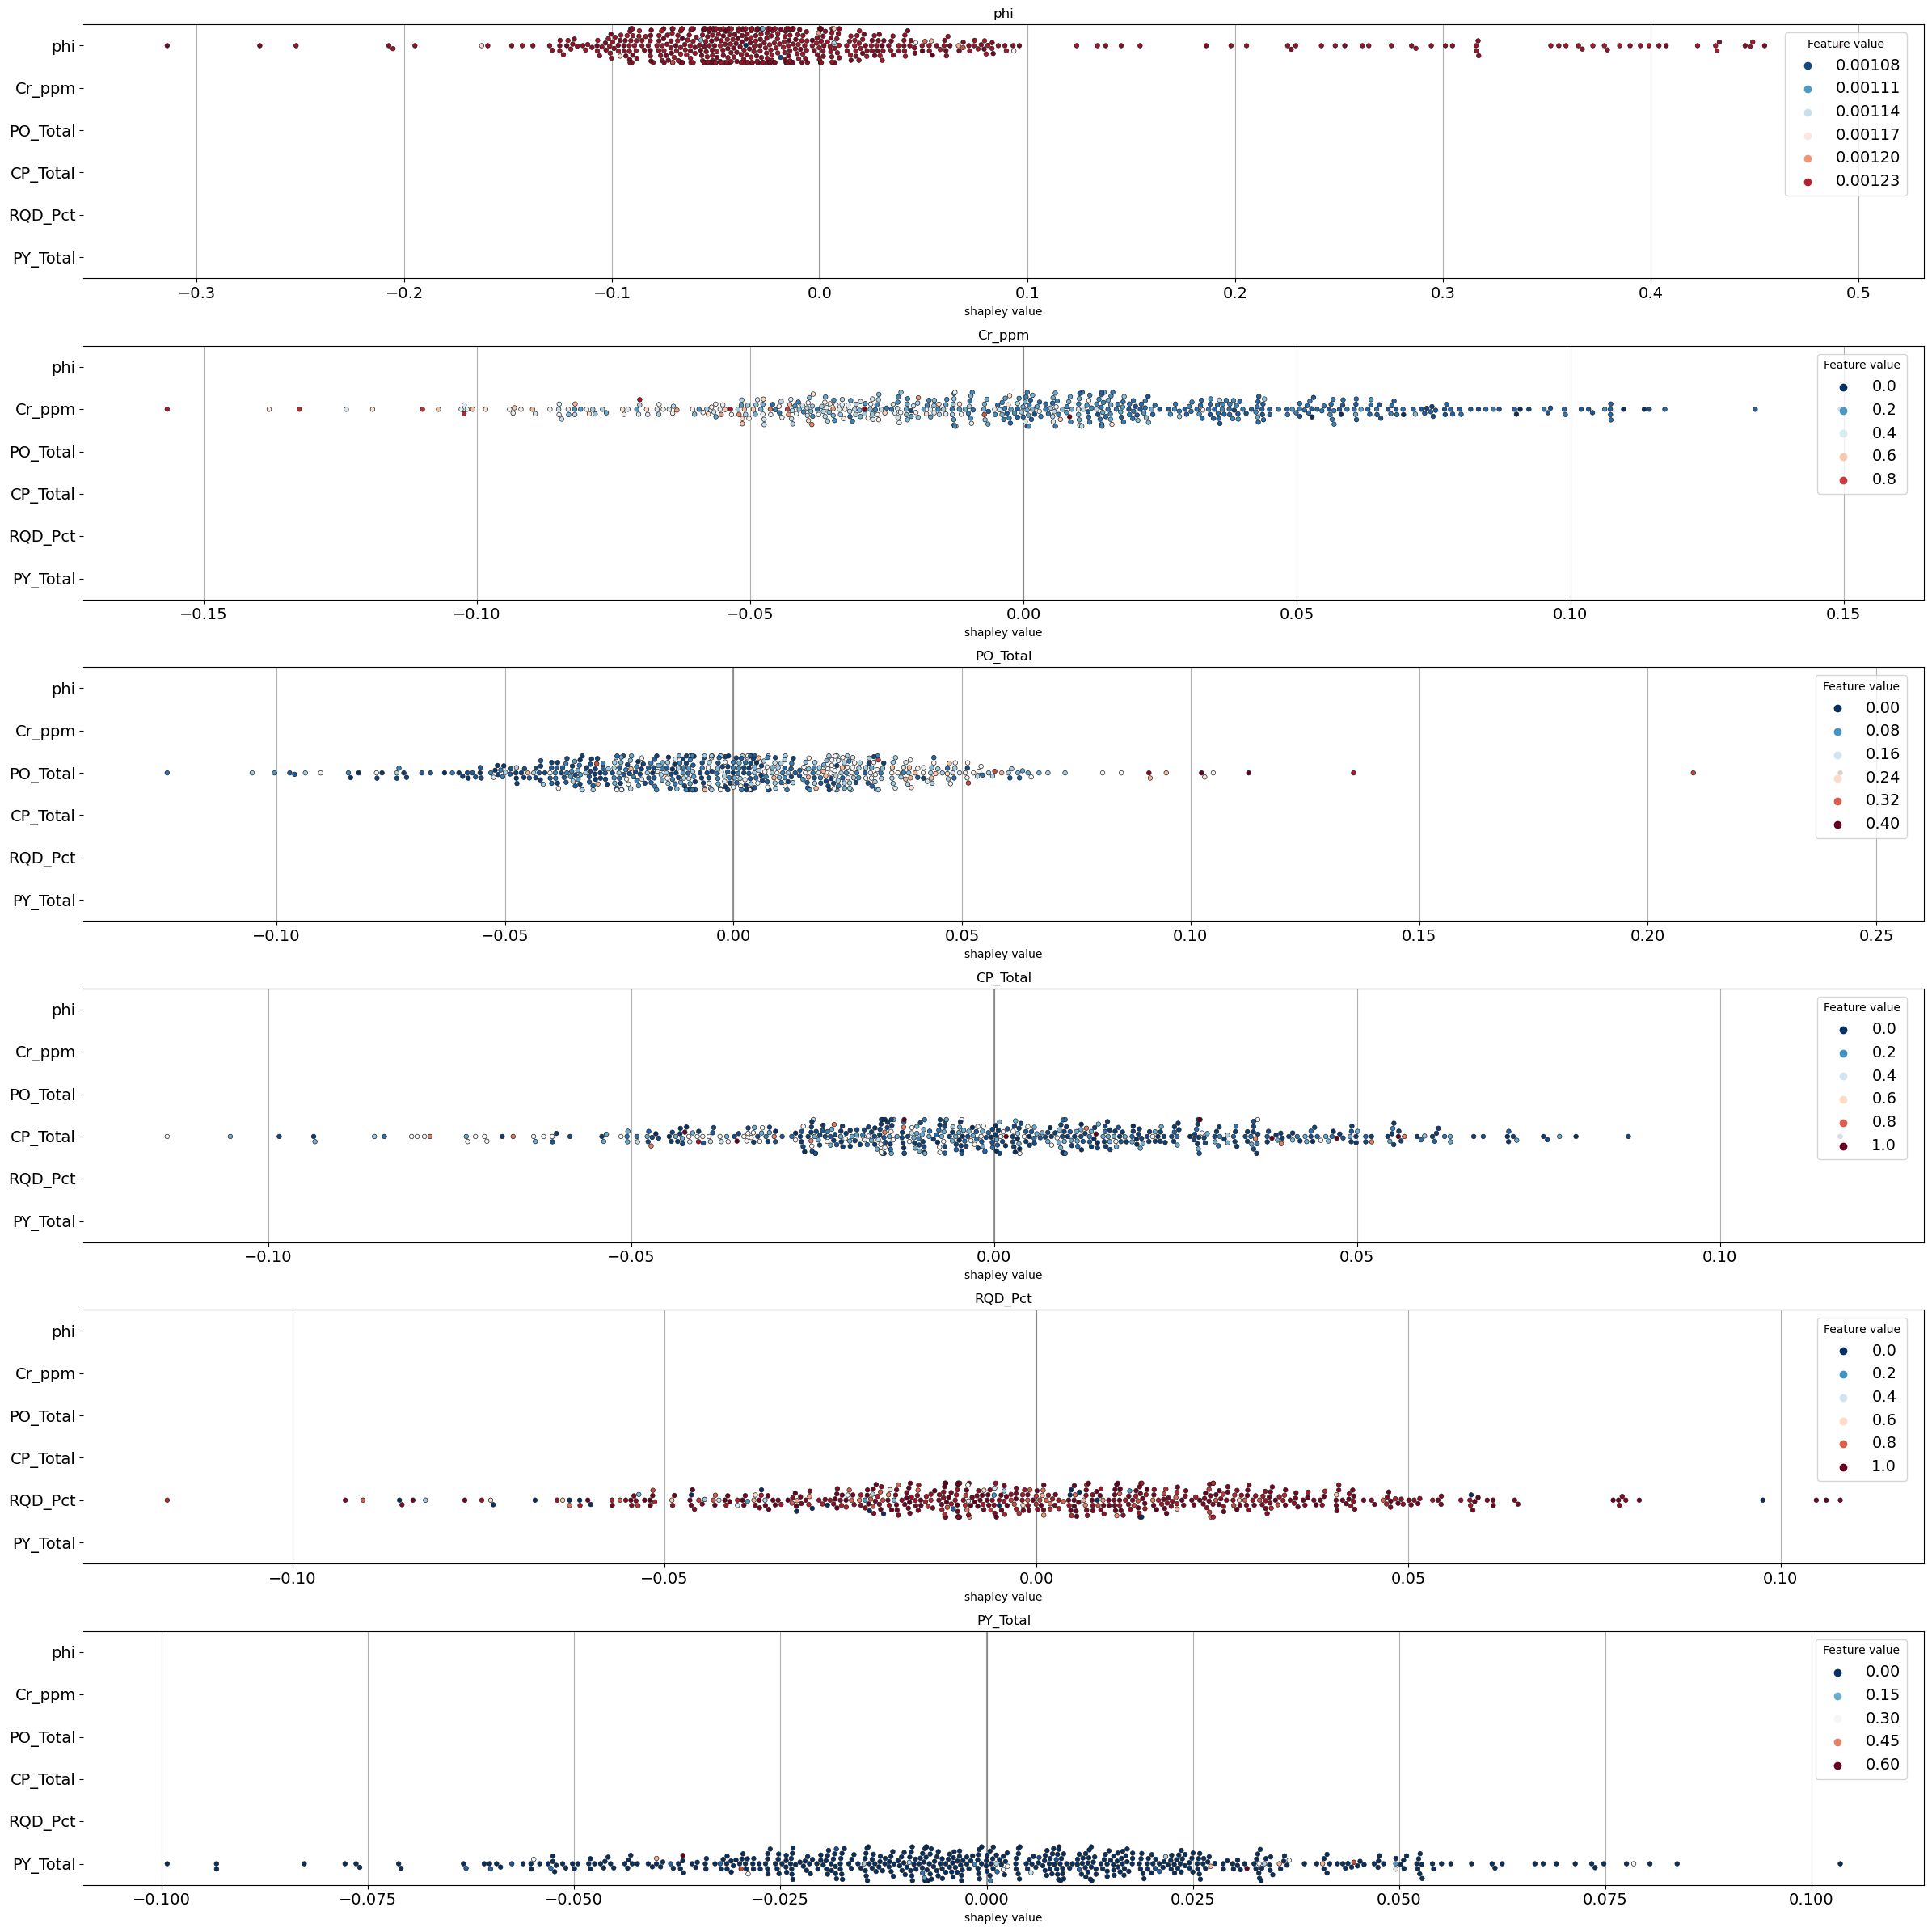

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_sv contains your data

# Get unique features from the dataframe
unique_features = df_sv['feature'].unique()

# Set up subplots for each feature
fig, axes = plt.subplots(nrows=len(unique_features), figsize=(24, 4 * len(unique_features)))

# Iterate through each feature and create a swarmplot
for i, feature in enumerate(unique_features):
    ax = axes[i]
    sns.swarmplot(
        x=df_sv[df_sv['feature'] == feature]['shapley value'],
        y=df_sv[df_sv['feature'] == feature]['feature'],
        hue=df_sv[df_sv['feature'] == feature]['hue'],
        palette=sns.color_palette("RdBu_r", as_cmap=True),
        size=4,
        linewidth=0.5,
        ax=ax
    )
    ax.axvline(0, c="grey", alpha=0.8)
    ax.spines.left.set_visible(False)
    ax.grid(axis='x')
    ax.set_ylabel("")
    ax.set_title(feature)  # Add feature name as title

    # Increase x-axis and y-axis tick font size
    ax.tick_params(axis='x', labelsize=14)  # Adjust the labelsize as needed
    ax.tick_params(axis='y', labelsize=14)  # Adjust the labelsize as needed

    # Increase overall legend font size
    ax.legend(title='Feature value', loc='upper right', bbox_to_anchor=(0.995, 1), borderaxespad=0.5, fontsize='14')

plt.tight_layout()
plt.show()


In [123]:
import plotly.graph_objects as go
import pandas as pd

# Assuming psi_CP_Total, psi_PO_Total, psi_PY_Total, psi_RQD_Pct, psi_Cr_ppm, psi_Random_Values,
# psi_phi, and X_test are your variables and DataFrame
# Replace these with your actual data

# Select a specific row (instance) from your dataset
instance_idx = 11  # Replace with the index of the instance you want to visualize
instance_row = X_test.iloc[instance_idx]

# Create a combined DataFrame for the waterfall plot
df_waterfall_combined = pd.DataFrame()

# List of features
features = ['CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm', 'phi']

# Populate the DataFrame with features, shapley values, and hue values
df_waterfall_combined['feature'] = features
df_waterfall_combined['shapley value'] = [
    psi_CP_Total[instance_idx],
    psi_PO_Total[instance_idx],
    psi_PY_Total[instance_idx],
    psi_RQD_Pct[instance_idx],
    psi_Cr_ppm[instance_idx],
    psi_phi[instance_idx]  # Include phi in the same DataFrame
]
df_waterfall_combined['source'] = ['Shapley'] * len(df_waterfall_combined)

# Create a Waterfall plot for both Shapley and Phi values
fig_waterfall_combined = go.Figure()

for source, color in zip(['Shapley'], ['#008bfb']):
    source_df = df_waterfall_combined[df_waterfall_combined['source'] == source]
    fig_waterfall_combined.add_trace(
        go.Waterfall(
            name=f"waterfall_{source}",
            orientation="h",
            y=source_df['feature'],
            x=source_df['shapley value'],
            base=0,  # Set the base value
            decreasing=dict(marker=dict(color='#ff0000')),  # Red color for decreasing values
            increasing=dict(marker=dict(color='#008bfb')),  # Blue color for increasing values
        )
    )

fig_waterfall_combined.update_layout(
    title="Waterfall Plot for Shapley Values (Single Instance)",
    width=1000, height=500, font=dict(size=14),
    paper_bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
    plot_bgcolor='rgba(0,0,0,0)'  # Set plot background color to transparent
)

# Save the figure

